# Building Neural Network from Scratch Part - 8

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import vertical_data, spiral_data

nnfs.init()

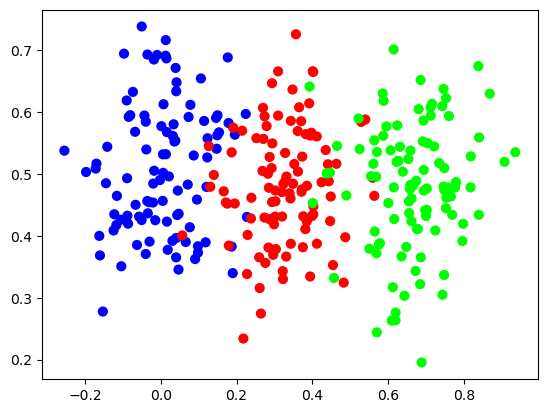

In [2]:
X, Y = vertical_data(samples = 100, classes = 3)
plt.scatter(X[:, 0], X[:, 1], c = Y, s = 40, cmap = 'brg')
plt.show()

### Creating Model

In [3]:
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, batch_inputs):
        # Calculate the output values from inputs, weights and biases
        self.output = np.dot(batch_inputs, self.weights) + self.biases

In [4]:
# ReLU activation
class Activation_ReLU:
    def forward(self, inputs):
        # Calculate the output value from input
        self.output = np.maximum(0, inputs)

In [5]:
# Softmax activation
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        
        # Assigning the probability values into output
        self.output = probabilities

In [6]:
# Base class for all loss functions
class Loss:
    
    # Calculates the mean loss over a batch of samples
    def calculate(self, output, y):
        
        # Perform the forward pass (implemented in derived class, e.g., CategoricalCrossEntropy)
        # This returns individual loss values for each sample in the batch
        sample_losses = self.forward(output, y)

        # Compute the average loss across all samples
        data_loss = np.mean(sample_losses)

        # Return the scalar average loss
        return data_loss

In [7]:
# Cross-entropy loss for classification tasks
# Inherits from a base Loss class
class Loss_CategoricalCrossEntropy(Loss):
    
    # Forward pass to compute the loss for each sample
    def forward(self, y_pred, y_true):
        
        # Get the number of samples in the batch
        no_samples = len(y_pred)

        # Clip predicted values to avoid log(0), which is undefined
        # Clipping prevents extremely small or large values that could cause numerical issues
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Case 1: Labels are integer class indices (e.g., [0, 2, 1])
        if len(y_true.shape) == 1:
            # Extract the confidence (probability) for the correct class for each sample
            # For each sample index `i`, get y_pred_clipped[i, y_true[i]]
            correct_confidences = y_pred_clipped[range(no_samples), y_true]

        # Case 2: Labels are one-hot encoded (e.g., [[1, 0, 0], [0, 1, 0]])
        elif len(y_true.shape) == 2:
            # Element-wise multiplication of predicted probs and true labels
            # Since only the correct class has a 1, this effectively selects the correct class confidence
            correct_confidences = np.sum(y_pred_clipped * y_true, axis = 1)

        # Compute the negative log of the correct class probabilities
        # This gives the cross-entropy loss for each sample
        negative_log_likelihoods = -np.log(correct_confidences)

        # Return the loss per sample (not averaged)
        return negative_log_likelihoods

### Strategy 1: Randomly Select Weights and Biases - Does Not Work!

In [8]:
# Create dataset
X, Y = vertical_data(samples = 100, classes = 3)

# Create model
dense_1 = Layer_Dense(2, 3) # First dense layer, 2 inputs 
activation_1 = Activation_ReLU()
dense_2 = Layer_Dense(3, 3) # Second dense layer, 3 inputs, 3 outputs
activation_2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossEntropy()

# Helper variables
lowest_loss = 9999999 # Some initial value
best_dense1_weights = dense_1.weights.copy()
best_dense1_biases = dense_1.biases.copy()
best_dense2_weights = dense_2.weights.copy()
best_dense2_biases = dense_2.biases.copy()

for iteration in range(100000):
    # Generate a new set of weights for iteration
    dense_1.weights = 0.05 * np.random.randn(2, 3)
    dense_1.biases = 0.05 * np.random.randn(1, 3)
    dense_2.weights = 0.05 * np.random.randn(3, 3)
    dense_2.biases = 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of the training data through this layer
    dense_1.forward(X)
    activation_1.forward(dense_1.output)
    dense_2.forward(activation_1.output)
    activation_2.forward(dense_2.output)

    # Perform a forward pass through activation function, 
    # it takes the output of second dense layer here and returns loss
    loss = loss_function.calculate(activation_2.output, Y)

    # Calculate accuracy from output of activation_2 and targets, 
    # calculate values along first axis
    predictions = np.argmax(activation_2.output, axis = 1)
    accuracy = np.mean(predictions == Y)

    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print("New set of weights found, iteration: ", iteration, "Loss: ", loss, "Accuracy: ", accuracy)
        best_dense1_weights = dense_1.weights.copy()
        best_dense1_biases = dense_1.biases.copy()
        best_dense2_weights = dense_2.weights.copy()
        best_dense2_biases = dense_2.biases.copy()
        lowest_loss = loss

New set of weights found, iteration:  0 Loss:  1.1016203 Accuracy:  0.3333333333333333
New set of weights found, iteration:  1 Loss:  1.1002508 Accuracy:  0.3333333333333333
New set of weights found, iteration:  2 Loss:  1.0992025 Accuracy:  0.3333333333333333
New set of weights found, iteration:  3 Loss:  1.0986239 Accuracy:  0.3333333333333333
New set of weights found, iteration:  10 Loss:  1.0984299 Accuracy:  0.3333333333333333
New set of weights found, iteration:  22 Loss:  1.0976521 Accuracy:  0.36333333333333334
New set of weights found, iteration:  150 Loss:  1.0974255 Accuracy:  0.3333333333333333
New set of weights found, iteration:  874 Loss:  1.0972673 Accuracy:  0.3333333333333333
New set of weights found, iteration:  894 Loss:  1.096895 Accuracy:  0.3333333333333333
New set of weights found, iteration:  1036 Loss:  1.0954281 Accuracy:  0.3333333333333333
New set of weights found, iteration:  88633 Loss:  1.0952065 Accuracy:  0.3333333333333333


### Strategy 2: Randomly Adjust Weights and Biases - Works!

In [9]:
# Create dataset
X, Y = vertical_data(samples = 100, classes = 3)

# Create model
dense_1 = Layer_Dense(2, 3) # First dense layer, 2 inputs 
activation_1 = Activation_ReLU()
dense_2 = Layer_Dense(3, 3) # Second dense layer, 3 inputs, 3 outputs
activation_2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossEntropy()

# Helper variables
lowest_loss = 9999999 # Some initial value
best_dense1_weights = dense_1.weights.copy()
best_dense1_biases = dense_1.biases.copy()
best_dense2_weights = dense_2.weights.copy()
best_dense2_biases = dense_2.biases.copy()

for iteration in range(10000):
    # Generate a new set of weights for iteration
    dense_1.weights += 0.05 * np.random.randn(2, 3)
    dense_1.biases += 0.05 * np.random.randn(1, 3)
    dense_2.weights += 0.05 * np.random.randn(3, 3)
    dense_2.biases += 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of the training data through this layer
    dense_1.forward(X)
    activation_1.forward(dense_1.output)
    dense_2.forward(activation_1.output)
    activation_2.forward(dense_2.output)

    # Perform a forward pass through activation function, 
    # it takes the output of second dense layer here and returns loss
    loss = loss_function.calculate(activation_2.output, Y)

    # Calculate accuracy from output of activation_2 and targets, 
    # calculate values along first axis
    predictions = np.argmax(activation_2.output, axis = 1)
    accuracy = np.mean(predictions == Y)

    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print("New set of weights found, iteration: ", iteration, "Loss: ", loss, "Accuracy: ", accuracy)
        best_dense1_weights = dense_1.weights.copy()
        best_dense1_biases = dense_1.biases.copy()
        best_dense2_weights = dense_2.weights.copy()
        best_dense2_biases = dense_2.biases.copy()
        lowest_loss = loss
    # Revert weights and biases
    else:
        dense_1.weights = best_dense1_weights.copy()
        dense_1.biases = best_dense1_biases.copy()
        dense_2.weights = best_dense2_weights.copy()
        dense_2.biases = best_dense2_biases.copy()

New set of weights found, iteration:  0 Loss:  1.1008747 Accuracy:  0.3333333333333333
New set of weights found, iteration:  3 Loss:  1.1005715 Accuracy:  0.3333333333333333
New set of weights found, iteration:  4 Loss:  1.099462 Accuracy:  0.3333333333333333
New set of weights found, iteration:  9 Loss:  1.099436 Accuracy:  0.3333333333333333
New set of weights found, iteration:  10 Loss:  1.09855 Accuracy:  0.3333333333333333
New set of weights found, iteration:  13 Loss:  1.098517 Accuracy:  0.3333333333333333
New set of weights found, iteration:  14 Loss:  1.0938607 Accuracy:  0.3333333333333333
New set of weights found, iteration:  15 Loss:  1.0920315 Accuracy:  0.3333333333333333
New set of weights found, iteration:  17 Loss:  1.0913911 Accuracy:  0.3333333333333333
New set of weights found, iteration:  19 Loss:  1.0910357 Accuracy:  0.3333333333333333
New set of weights found, iteration:  20 Loss:  1.0898421 Accuracy:  0.3333333333333333
New set of weights found, iteration:  21 

### Strategy 2: For Spiral Dataset - Does Not Work!

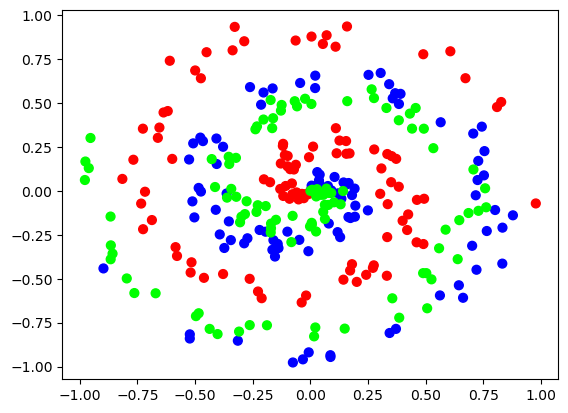

In [10]:
X, Y = spiral_data(samples = 100, classes = 3)
plt.scatter(X[:, 0], X[:, 1], c = Y, s = 40, cmap = 'brg')
plt.show()

In [11]:
# Create dataset
X, Y = spiral_data(samples = 100, classes = 3)

# Create model
dense_1 = Layer_Dense(2, 3) # First dense layer, 2 inputs 
activation_1 = Activation_ReLU()
dense_2 = Layer_Dense(3, 3) # Second dense layer, 3 inputs, 3 outputs
activation_2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossEntropy()

# Helper variables
lowest_loss = 9999999 # Some initial value
best_dense1_weights = dense_1.weights.copy()
best_dense1_biases = dense_1.biases.copy()
best_dense2_weights = dense_2.weights.copy()
best_dense2_biases = dense_2.biases.copy()

for iteration in range(10000):
    # Generate a new set of weights for iteration
    dense_1.weights += 0.05 * np.random.randn(2, 3)
    dense_1.biases += 0.05 * np.random.randn(1, 3)
    dense_2.weights += 0.05 * np.random.randn(3, 3)
    dense_2.biases += 0.05 * np.random.randn(1, 3)

    # Perform a forward pass of the training data through this layer
    dense_1.forward(X)
    activation_1.forward(dense_1.output)
    dense_2.forward(activation_1.output)
    activation_2.forward(dense_2.output)

    # Perform a forward pass through activation function, 
    # it takes the output of second dense layer here and returns loss
    loss = loss_function.calculate(activation_2.output, Y)

    # Calculate accuracy from output of activation_2 and targets, 
    # calculate values along first axis
    predictions = np.argmax(activation_2.output, axis = 1)
    accuracy = np.mean(predictions == Y)

    # If loss is smaller - print and save weights and biases aside
    if loss < lowest_loss:
        print("New set of weights found, iteration: ", iteration, "Loss: ", loss, "Accuracy: ", accuracy)
        best_dense1_weights = dense_1.weights.copy()
        best_dense1_biases = dense_1.biases.copy()
        best_dense2_weights = dense_2.weights.copy()
        best_dense2_biases = dense_2.biases.copy()
        lowest_loss = loss
    # Revert weights and biases
    else:
        dense_1.weights = best_dense1_weights.copy()
        dense_1.biases = best_dense1_biases.copy()
        dense_2.weights = best_dense2_weights.copy()
        dense_2.biases = best_dense2_biases.copy()

New set of weights found, iteration:  0 Loss:  1.099395 Accuracy:  0.3333333333333333
New set of weights found, iteration:  9 Loss:  1.0992345 Accuracy:  0.3333333333333333
New set of weights found, iteration:  10 Loss:  1.0986273 Accuracy:  0.3333333333333333
New set of weights found, iteration:  15 Loss:  1.0982343 Accuracy:  0.3333333333333333
New set of weights found, iteration:  16 Loss:  1.0974435 Accuracy:  0.3333333333333333
New set of weights found, iteration:  17 Loss:  1.0964532 Accuracy:  0.36666666666666664
New set of weights found, iteration:  19 Loss:  1.0948596 Accuracy:  0.3433333333333333
New set of weights found, iteration:  24 Loss:  1.09397 Accuracy:  0.39
New set of weights found, iteration:  28 Loss:  1.0930235 Accuracy:  0.38333333333333336
New set of weights found, iteration:  29 Loss:  1.0927234 Accuracy:  0.36333333333333334
New set of weights found, iteration:  31 Loss:  1.0920335 Accuracy:  0.39
New set of weights found, iteration:  33 Loss:  1.0913504 Accu